 # Classificação de Sentimentos no Dataset "Restaurant Reviews" com o Modelo DistilBERT.

### Descrição do Dataset

Nesse trabalho, será analisado um dataset que contém reviews de restaurantes europeus. O dataset inclui informações como o o nome do restaurante, o país em que ele está localizado, o sentimento da avaliação (positivo ou negativo), o título da avaliação e o conteúdo da avaliação.

### Carregamento do Dataset



In [1]:
import pandas as pd
df=pd.read_csv("European Restaurant Reviews.csv")

 Visualização do conteúdo e da estrutura do dataset

In [2]:
df.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


Quantidade de observações, quantidade de dados ausentes e tipo de cada coluna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB


Conclusão do carregamento

O Dataset possui 1502 observações com 6 colunas: Country (País), Restaurant Name (Nome do Restaurante), Review Title (Título da Avaliação), Review Date (Data da Avaliação), Review (Avaliação) e não possui nenhum dado ausente em nenhuma das 6 colunas, portanto, não será necessária nenhuma técnica de pré-processamento para lidar com dados ausentes. Todas as colunas são do tipo object (string).

### Informações do dataset

In [4]:
df.describe()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
count,1502,1502,1502,1502,1502,1502
unique,7,7,2,1343,143,1426
top,France,The Frog at Bercy Village,Positive,Excellent,May 2014 •,I'm afraid we were very let down by this resta...
freq,512,512,1237,9,108,4


O dataset contém dados de 7 restaurantes de 7 diferentes países.

Distribuição de sentimentos

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

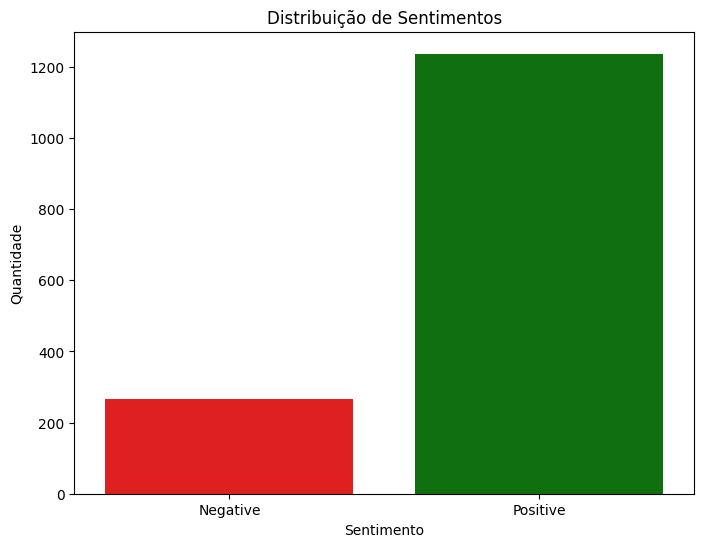

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(x="Sentiment", data=df, hue="Sentiment" ,palette=['red', 'green'], legend=False) 
plt.title("Distribuição de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

Das 1502 observações, 1237 são positivas e 265 negativas.

Média de tamanho da avaliação de acordo com o sentimento

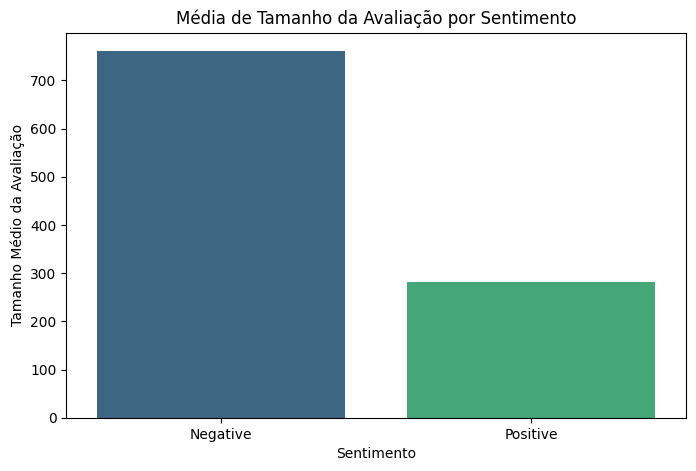

In [7]:
df['Review Length'] = df['Review'].apply(len)
avg_review_length = df.groupby('Sentiment')['Review Length'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_review_length.index, y=avg_review_length.values, hue=avg_review_length.index,palette='viridis')
plt.title('Média de Tamanho da Avaliação por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Tamanho Médio da Avaliação')
plt.show()

Esse gráfico mostra que as avaliações negativas tendem a ser muito mais longas do que as avaliações positivas (As positivas costumam ter cerca de 300 caracteres, enquanto as positivas costumam ter cerca de 700 caracteres). Isso evidencia que, quando os clientes estão insatisfeitos, eles costumam avaliar de forma mais detalhada em comparação a quando eles estão satisfeitos. Esse elemento pode ser utilizado pelo modelo de classificação de sentimentos para uma classificação mais precisa.

Quantidade de avaliações separadas por país

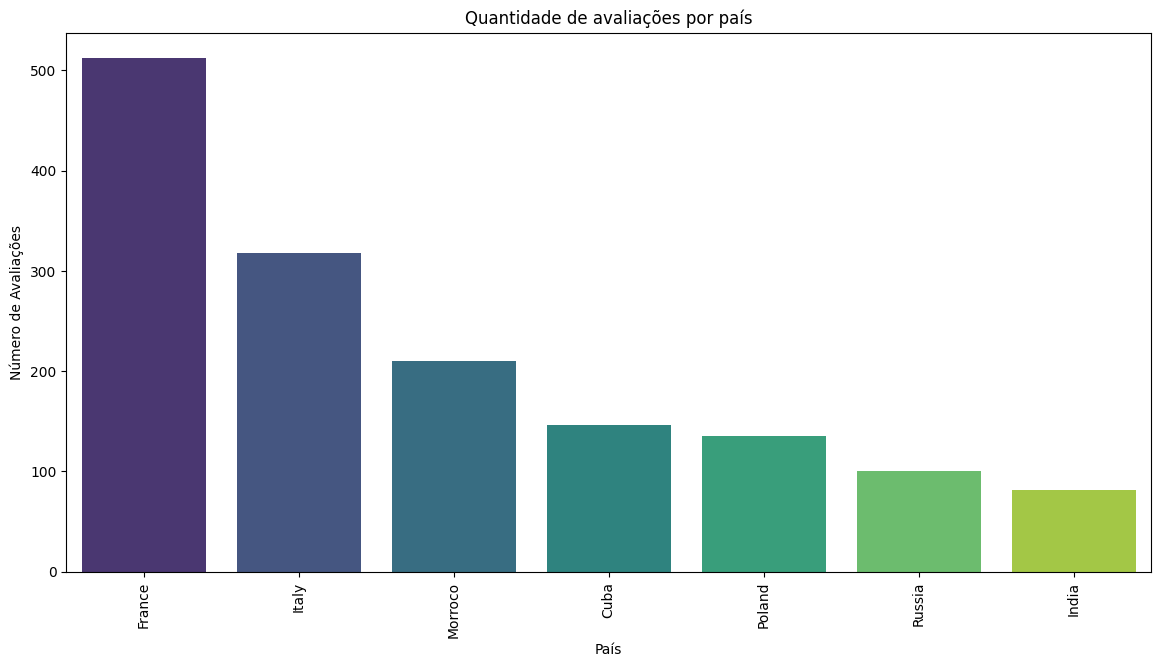

In [8]:
plt.figure(figsize=(14,7))
country_count=df["Country"].value_counts()
sns.barplot(x=country_count.index,y=country_count.values, hue=country_count.index, palette="viridis")
plt.title("Quantidade de avaliações por país")
plt.xlabel("País")
plt.ylabel("Número de Avaliações")
plt.xticks(rotation=90)
plt.show()

In [9]:
# Para processamento de texto
import re
import nltk

# Para remover palavras comuns
from nltk.corpus import stopwords
nltk.download('stopwords')

# Para stemming - lematização
from nltk.stem.porter import PorterStemmer

# Para tokenização
from nltk.tokenize import word_tokenize ,sent_tokenize
nltk.download('punkt')

def limparTexto(text):
    # Convert to lowercase
    text = text.lower()
    # Remove commas
    text = re.sub(r',', '', text)
    # Remove single quotation marks
    text = re.sub(r'\'', '', text)
    # Remove double quotation marks
    text = re.sub(r'\"', '', text)
    # Remove opening parentheses 
    text = re.sub(r'\(', '', text)
    # Remove closing parentheses   
    text = re.sub(r'\)', '', text)
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove left double quotation marks  
    text = re.sub(r'“', '', text)
    # Remove right double quotation marks
    text = re.sub(r'”', '', text)
    # Remove right single quotation marks
    text = re.sub(r'’', '', text)
    # Remove periods
    text = re.sub(r'\.', '', text)
    # Remove semicolons
    text = re.sub(r';', '', text)
    # Remove colons 
    text = re.sub(r':', '', text)
    # Remove hyphens 
    text = re.sub(r'\-', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Return the cleaned text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aderson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aderson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Aplica limparTexto na coluna 'Review'
df['cleaned_review'] = df['Review'].apply(limparTexto)
df['cleaned_review']

0       the manager became agressive when i said the c...
1       i ordered a beef fillet ask to be done medium ...
2       this is an attractive venue with welcoming alb...
3       sadly i  used the high tripadvisor rating too ...
4       from the start this meal was bad especially gi...
                              ...                        
1497    despite the other reviews saying that this is ...
1498    beer is good  food is awfull  the only decent ...
1499    for terrible service of a truly comedic level ...
1500    we visited the havanas club museum which is lo...
1501    food and service was awful very pretty stop go...
Name: cleaned_review, Length: 1502, dtype: object

In [11]:
# Remove stop words
def Remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    text = ' '.join(words)
    return text

# Aplicar o Remove_stop_words na coluna 'cleaned_review' 
df['cleaned_review'] = df['cleaned_review'].apply(Remove_stop_words)

df.head(5)

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review,Review Length,cleaned_review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...,146,manager became agressive said carbonara good r...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,...",281,ordered beef fillet ask done medium got well d...
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al...",260,attractive venue welcoming albeit somewhat slo...
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...,1513,sadly used high tripadvisor rating literally f...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...,1351,start meal bad especially given price visited ...


In [12]:
# Tokenizar todas as frases do cleaned_version 
df['cleaned_review_tokens'] = df['cleaned_review'].apply(lambda x: x.split())
texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()


Os países da parte central da Europa possuem uma quantidade maior de avaliações, evidenciando uma possível cultura culinária mais forte nesses países.

Nuvem de palavras mais utilizadas em avaliações positivas

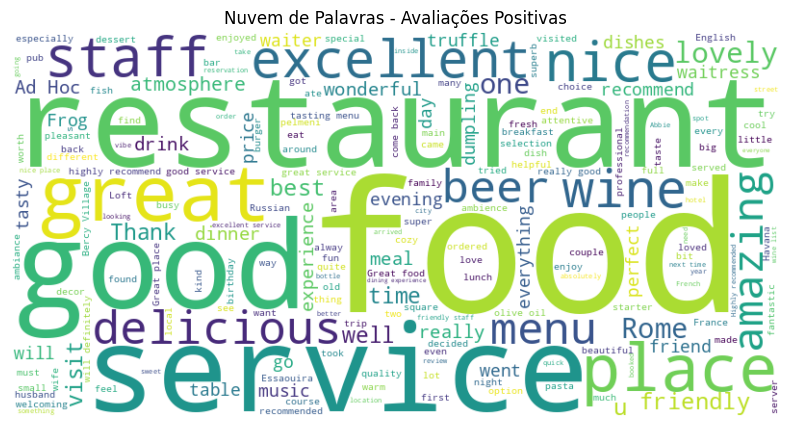

In [13]:
from wordcloud import WordCloud

positive_reviews = df[df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Positivas')
plt.axis('off')
plt.show()

Nuvem de palavras mais utilizadas em avaliações negativas

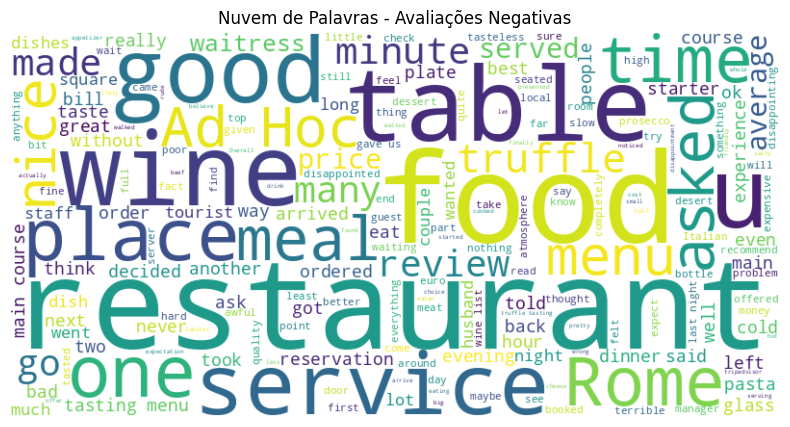

In [14]:
from wordcloud import WordCloud

positive_reviews = df[df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Negativas')
plt.axis('off')
plt.show()

As palavras mais frequentes para cada tipo de sentimento são importantes informações para o modelo de linguagem classificar sentimentos com a maior acurácia possível. Porém, algumas palavras podem estar igualmente presentes em grande quantidade em ambos os sentimentos, como a palavra "restaurante", por exemplo.

Média de sentimentos ao longo do tempo

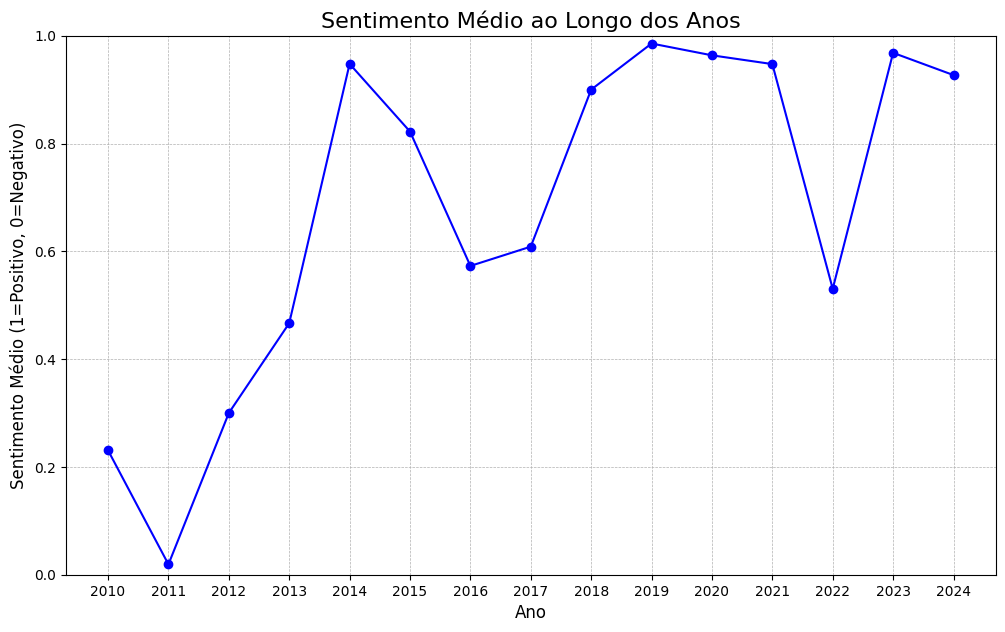

In [15]:
import re
import matplotlib.pyplot as plt
import pandas as pd

df_temp = df.copy()

# Extrair mês e ano (ex: "May 2024")
df_temp['Review Date'] = df_temp['Review Date'].str.extract(r'([A-Za-z]+\s+\d{4})')

# Corrigir abreviação não padrão "Sept"
df_temp['Review Date'] = df_temp['Review Date'].str.replace('Sept', 'Sep')

# Converter para datetime (dia 1 por padrão)
df_temp['Review Date'] = pd.to_datetime(df_temp['Review Date'], format='%b %Y', errors='coerce')

# Mapear sentimentos para valores numéricos
df_temp['Sentiment_Value'] = df_temp['Sentiment'].map({'Positive': 1, 'Negative': 0})

# Média de sentimento por ano
sentiment_by_year = df_temp.groupby(df_temp['Review Date'].dt.year)['Sentiment_Value'].mean()

# Plotar
plt.figure(figsize=(12, 7))
sentiment_by_year.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Sentimento Médio ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Sentimento Médio (1=Positivo, 0=Negativo)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(sentiment_by_year.index)
plt.ylim(0, 1)
plt.show()


In [16]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os

texts = df['cleaned_review_tokens'].apply(lambda tokens: ' '.join(tokens)).tolist()

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    # Processa em batches para evitar uso excessivo de memória
    batch_size = 8
    sentiment_map = {0: "Muito Negativo", 1: "Negativo", 2: "Neutro", 3: "Positivo", 4: "Muito Positivo"}
    all_preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).tolist()
        all_preds.extend([sentiment_map[p] for p in preds])
    return all_preds

resultados = predict_sentiment(texts)

for original, processed, sentiment in zip(df['Review'], texts, resultados):
    print(f"Texto original:\n{original}")
    print(f"Texto processado:\n{processed}")
    print(f"Sentimento: {sentiment}")
    print("-" * 80)


/home/aderson/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aderson/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Texto original:
The manager became agressive when I said the carbonara was not good. She was rude. It was  a very bad experience. The worst in Rome in many years.
Texto processado:
manager became agressive said carbonara good rude bad experience worst rome many years
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price.
Texto processado:
ordered beef fillet ask done medium got well done cooked dry told took steak 20 minutes brought another steak completely rare left steak asked charged fool price
Sentimento: Muito Negativo
--------------------------------------------------------------------------------
Texto original:
This is an attractive 